In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
train_df.shape, test_df.shape

((27455, 785), (7172, 785))

In [8]:
y_train = train_df['label']
X_train = train_df.drop(columns=['label'])

y_test = test_df['label']
X_test = test_df.drop(columns=['label'])

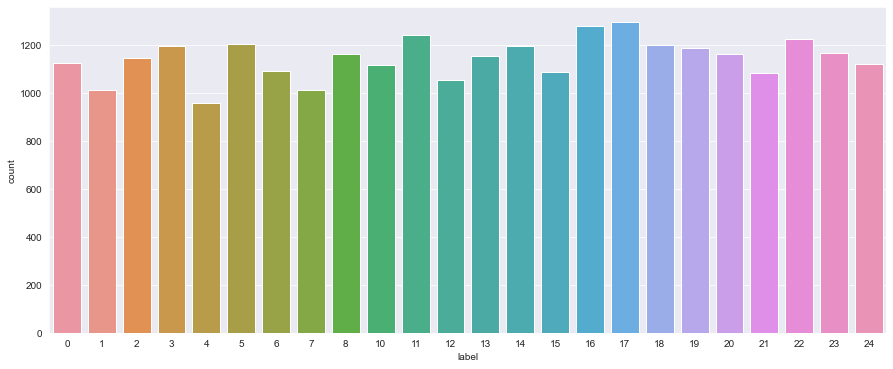

In [11]:
plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
sns.countplot(y_train)
plt.show()

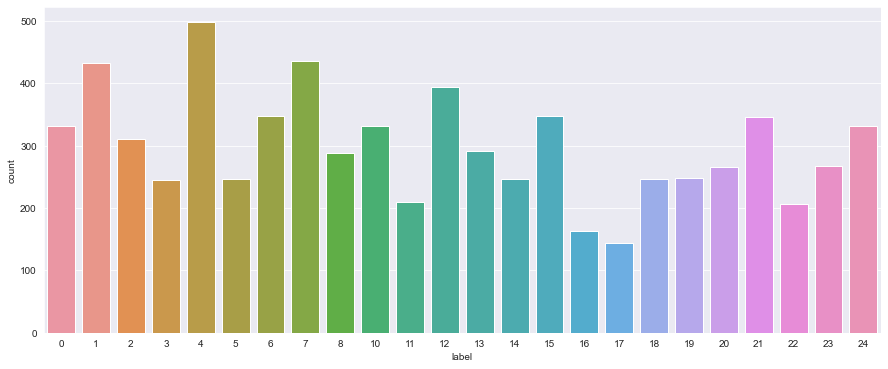

In [12]:
plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
sns.countplot(y_test)
plt.show()

In [ ]:
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns

In [ ]:
# Rename label into Label
train_df.rename(columns={'label':'Label'},inplace = True)
test_df.rename(columns={'label':'Label'},inplace = True)

# Shuffle
train_df = train_df.sample(frac = 1.0).reset_index(drop = True)
test_df = test_df.sample(frac = 1.0).reset_index(drop = True)

In [ ]:
train_df_original = train_df.copy()

# Split into training, test and validation sets
val_index = int(train_df.shape[0]*0.1)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train_df['Label']
y_val = val_df['Label']
y_test = test_df['Label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('Label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('Label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test_df.drop('Label',axis = 1).values.reshape(test_df.shape[0], 28, 28, 1)

In [ ]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

In [ ]:
X_train_flow = generator.flow(X_train, y_train, batch_size=32)
X_val_flow = generator.flow(X_val, y_val, batch_size=32)

In [ ]:
model = Sequential([Conv2D(filters=32,  kernel_size=(4,4), activation="relu", padding = "same", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding="same"),
                    
                    Conv2D(filters= 64 ,  kernel_size=(3,3), activation="relu",padding = "same"),
                    MaxPool2D(2,2, padding="same"),
                    
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding="same"),
                    
                    Conv2D(filters=512, kernel_size=(2,2), activation="relu"),
                    MaxPool2D(2,2, padding="same"),
                    
                    Flatten(),
                    
                    Dense(units=1024, activation="relu"),                 
                    Dense(units=256, activation="relu"),
                    Dropout(0.3),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.summary()

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, 
                    validation_data=X_val_flow, 
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True), 
                        
                            learning_rate_reduction
                    ])

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
print(f'{acc*100:.2f}% accuracy on the test set')